### Imports

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.express as px


## Method Definitions

In [32]:
def load_data_sets(data_path, label_path):
    
    # load data recordings from csv
    data_raw = pd.read_csv(data_path,sep=",", header=0)
    data_raw = data_raw.drop(['acc_x','acc_y','acc_z','roll', 'pitch', 'yaw','event'], axis=1)
    data_datetime = data_raw.copy()
    for row in range(0, len(data_datetime)):
        data_datetime.iloc[row, 0] = datetime.datetime.fromtimestamp(data_datetime.iloc[row, 0] / 1e3).strftime('%Y-%m-%d %H:%M:%S.%f')
    
    # load labels from csv
    data_labels = pd.read_csv(label_path, sep=";", header=0)
    reduced_data_labels = data_labels[['Time', 'trl', 'nosezone.touches', 'mouthzone.touches', 'eyezone.right eye', 'eyezone.left eye']].copy()
    reduced_data_labels.columns = ['timeAfterStart', 'isTouch', 'nose', 'mouth', 'rightEye', 'leftEye']
    return data_raw, data_datetime, reduced_data_labels

In [33]:
def plot_data_recordings(data, start, end):
    plt.figure(figsize=(20,10))
    plt.plot(data.iloc[start:end, 1:5])
    plt.show()

In [34]:
def get_timestamp_from_recording(data, row):
    return data.iloc[row, 0]

In [35]:
def obtain_final_labels(reduced_data_label):
    labels = []
    record_start_index = math.inf
    
    for index in range(len(reduced_data_label)):


        if reduced_data_label.iloc[index, 1] == 1:
            if index < record_start_index:
                record_start_index = index

            touch_zone = np.argmax(reduced_data_label.iloc[index, 2:6]) + 2
            #touch_zone = np.argwhere(reduced_data_label.columns.values == touch_zone)[0][0]
        
            zone = reduced_data_label.columns[touch_zone]

            if zone == 'nose':
                label = 1
            elif zone == 'mouth':
                label = 2
            elif zone == 'rightEye':
                label = 3
            elif zone == 'leftEye':
                label = 4
            labels.append(label)

        else:
            if index > record_start_index:
                label = 0

                labels.append(label)

    reduced_data_label = reduced_data_label.drop(range(record_start_index), axis = 0)
    reduced_data_label = reduced_data_label.reset_index(drop=True)
    reduced_data_label['label'] = labels
    
    return reduced_data_label

In [36]:
def generated_timestamps_in_label_data(reduced_data_label, timestamp):
    reduced_data_label['timestamp'] = np.zeros(len(reduced_data_label), dtype=np.longlong)
    reduced_data_label.iloc[0,-1] = timestamp #1594149273330
    for index in range(1, len(reduced_data_label)):
        reduced_data_label.iloc[index, -1] = reduced_data_label.iloc[0, -1] + (reduced_data_label.iloc[index, 0] - reduced_data_label.iloc[0,0]) * 1000
    return reduced_data_label

In [37]:
def join_recordings_with_labels(data_raw, reduced_data_label):
    index_data=0
    data_raw['label'] = np.zeros(len(data_raw), dtype=np.int)

    for index_label in range(0, len(reduced_data_label) - 1):
        timestamp_label = reduced_data_label.iloc[index_label,-1]
        while index_data < len(data_raw):
            timestamp_data = data_raw.iloc[index_data,0]
            if timestamp_data < timestamp_label:
                index_data += 1
            elif timestamp_data >= timestamp_label:
                if timestamp_data < reduced_data_label.iloc[index_label + 1,-1]:
                    data_raw.iloc[index_data, -1] = reduced_data_label.iloc[index_label, -2]
                    index_data += 1
                else:
                    break
    return data_raw

In [38]:
def export_to_csv(dataset, path):
    dataset.to_csv(path, index = False, header=True, sep=';')
    return 'exported successfully'

## Apply Preprocessing

In [48]:
raw, data_tmps, label_data = load_data_sets('2020-07-08_15-39-18.csv', '2020-07-08-15_37_09_Andrea_annotated.csv')


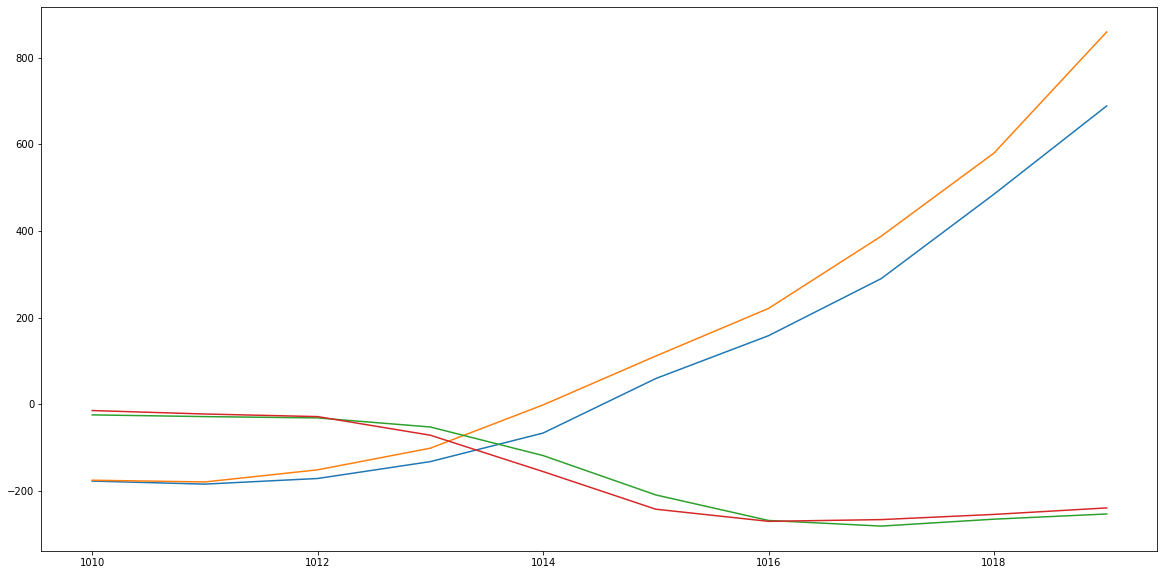

In [51]:
plot_data_recordings(data_tmps, 1010, 1020)

In [55]:
timestamp = get_timestamp_from_recording(raw, 1012)
timestamp

1594215578342

In [56]:
label_data = obtain_final_labels(label_data)
label_data = generated_timestamps_in_label_data(label_data, timestamp)
data_with_labels = join_recordings_with_labels(raw, label_data)
data_with_labels

,#timestamp,left1,left2,right2,right2.1,label
0,1594215558097,-27,-94,146,54,0
1,1594215558119,-50,-98,119,50,0
2,1594215558142,-38,-106,133,40,0
3,1594215558157,-17,-68,156,82,0
4,1594215558179,-20,-78,156,77,0
...,...,...,...,...,...,...
24516,1594216048473,-38,-49,107,91,0
24517,1594216048495,-49,-53,100,86,0
24518,1594216048511,-43,-44,104,91,0
24519,1594216048533,-32,-39,112,98,0


In [1]:

df = data_with_labels

# Use directly Columns as argument. You can use tab completion for this!
fig = px.scatter(df, x=data_tmps['#timestamp'], y=df['left2'], color=df['label'])
fig.show()

NameError: name 'data_with_labels' is not defined

In [58]:
export_to_csv(data_with_labels, 'preprocessed_data_a_05.csv')

'exported successfully'